# 7. Sequential RandomizedSearchCV

In [2]:
import joblib
import os

import pandas as pd

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Dense
from keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasRegressor

import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
%run ./scripts/store_model_performance.py
%run ./scripts/atomic_benchmark_estimator.py

In [4]:
df = pd.read_pickle("./pickles/003.dataframe.data-preprocessing.pkl")
df

,price,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,review_scores_rating,...,Shampoo,Smoke alarm,Stove,TV,Washer,Wifi,Entire place,Hotel room,Private room,Shared room
0,53,0,0.000138,1,0,0.543185,0.012963,0.066667,0.0,1.0,...,0,0,0,0,1,1,1.0,0.0,0.0,0.0
1,120,0,0.000138,1,1,0.543180,0.013029,0.066667,0.0,1.0,...,1,0,0,0,1,1,1.0,0.0,0.0,0.0
2,89,0,0.000138,1,0,0.543124,0.012873,0.066667,0.0,1.0,...,0,0,0,1,1,1,1.0,0.0,0.0,0.0
3,58,0,0.000138,1,1,0.542730,0.012810,0.066667,0.0,1.0,...,0,0,0,1,0,1,1.0,0.0,0.0,0.0
4,60,0,0.000138,1,0,0.542833,0.012610,0.066667,0.0,1.0,...,0,0,0,1,1,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279707,120,0,0.000138,1,1,0.542522,0.012857,0.066667,0.0,1.0,...,0,1,0,1,1,1,1.0,0.0,0.0,0.0
279708,60,0,0.000138,1,1,0.543257,0.012956,0.066667,0.0,1.0,...,1,0,0,1,1,1,1.0,0.0,0.0,0.0
279709,50,0,0.000138,1,1,0.543189,0.013051,0.066667,0.0,1.0,...,1,0,0,0,1,1,1.0,0.0,0.0,0.0
279710,105,0,0.000138,1,1,0.542965,0.013229,0.066667,0.0,1.0,...,1,1,0,1,1,1,1.0,0.0,0.0,0.0


## 7.1. RandomizedSearchCV

In [5]:
input_size = df.shape[1] - 1
input_size

63

In [9]:
def create_model_3(first_n_nodes, n_nodes_1, n_nodes_2, n_nodes_3):
    model = keras.models.Sequential()

    model.add(Dense(first_n_nodes, input_shape=(input_size,), activation="tanh"))

    model.add(Dense(n_nodes_1, activation="tanh"))
    model.add(Dense(n_nodes_2, activation="tanh"))
    model.add(Dense(n_nodes_3, activation="tanh"))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer="adam",
        loss="mae",
    )
    
    return model

In [6]:
n_nodes = [5, 10, 32, 63, 126]
n_nodes

[5, 10, 32, 63, 126]

In [7]:
params = {
    "batch_size": list(range(10, 100, 30)),
    **{k: n_nodes for k in ["first_n_nodes", "n_nodes_1", "n_nodes_2", "n_nodes_3"]}
}

In [8]:
early_stopping_monitor = EarlyStopping(patience=2, monitor="loss")
early_stopping_monitor

In [9]:
keras_regressor = KerasRegressor(
    model=create_model_3,
    verbose=3,
    epochs=40,
    callbacks=[early_stopping_monitor],
    **{n: params[n][0] for n in params},
)

In [10]:
search = RandomizedSearchCV(
    estimator=keras_regressor,
    param_distributions=params,
    n_jobs=10,
    n_iter=15,
    cv=6,
    scoring="neg_mean_absolute_error",
    verbose=3,
    error_score="raise",
    random_state=42
)

In [11]:
df.iloc[:, 1:].to_numpy()

array([[0.00000000e+00, 1.38217001e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.38217001e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.38217001e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.38217001e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.38217001e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.38217001e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [12]:
df.iloc[:, :1].to_numpy()

array([[53],
       [120],
       [89],
       ...,
       [50],
       [105],
       [70]], dtype=object)

In [13]:
search.fit(df.iloc[:, 1:].to_numpy(), df.iloc[:, :1].to_numpy(), verbose=3)

Fitting 6 folds for each of 15 candidates, totalling 90 fits


C:\Users\lande\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40


RandomizedSearchCV(cv=6, error_score='raise',
                   estimator=KerasRegressor(batch_size=10, callbacks=[<keras.callbacks.EarlyStopping object at 0x000002D32B5A0790>], epochs=40, first_n_nodes=5, model=<function create_model_3 at 0x000002D32B59E0C0>, n_nodes_1=5, n_nodes_2=5, n_nodes_3=5, verbose=3),
                   n_iter=15, n_jobs=10,
                   param_distributions={'batch_size': [10, 40, 70],
                                        'first_n_nodes': [5, 10, 32, 63, 126],
                                        'n_nodes_1': [5, 10, 32, 63, 126],
                                        'n_nodes_2': [5, 10, 32, 63, 126],
                                        'n_nodes_3': [5, 10, 32, 63, 126]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=3)

In [14]:
search.best_params_

{'n_nodes_3': 126,
 'n_nodes_2': 63,
 'n_nodes_1': 10,
 'first_n_nodes': 63,
 'batch_size': 40}

In [29]:
pd.DataFrame(search.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_nodes_3,param_n_nodes_2,param_n_nodes_1,param_first_n_nodes,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
7,296.505198,12.579308,3.112833,0.429981,126,63,10,63,40,"{'n_nodes_3': 126, 'n_nodes_2': 63, 'n_nodes_1...",-186.424852,-489.524570,-412.051405,-326.633738,-469.168962,-191.187342,-345.831812,122.432806,1
6,239.481273,3.235245,1.914994,0.424711,126,126,63,63,70,"{'n_nodes_3': 126, 'n_nodes_2': 126, 'n_nodes_...",-185.573152,-493.177282,-411.266806,-328.856297,-473.193277,-187.015348,-346.513694,124.769290,2
1,154.744326,2.618644,1.340162,0.246758,126,10,63,10,70,"{'n_nodes_3': 126, 'n_nodes_2': 10, 'n_nodes_1...",-187.295518,-504.935018,-415.858712,-326.296187,-478.174307,-189.452695,-350.335406,127.527947,3
11,305.350532,8.578520,2.493365,0.286830,63,32,126,126,40,"{'n_nodes_3': 63, 'n_nodes_2': 32, 'n_nodes_1'...",-187.893898,-503.340187,-415.447661,-325.037219,-484.362166,-188.470188,-350.758553,128.348326,4
3,160.223588,3.076567,1.822494,0.377481,126,63,10,5,70,"{'n_nodes_3': 126, 'n_nodes_2': 63, 'n_nodes_1...",-188.728259,-501.971764,-419.424981,-335.071863,-488.852507,-187.950492,-353.666644,128.844910,5
8,164.703493,6.131506,1.775646,0.587658,63,32,5,63,70,"{'n_nodes_3': 63, 'n_nodes_2': 32, 'n_nodes_1'...",-185.265660,-515.910261,-414.645305,-324.160581,-494.742171,-188.103293,-353.804545,133.281845,6
14,752.875559,35.088759,2.708219,0.429640,32,32,63,5,10,"{'n_nodes_3': 32, 'n_nodes_2': 32, 'n_nodes_1'...",-195.686921,-513.266239,-418.961837,-333.734636,-490.454054,-189.395515,-356.916534,129.565170,7
13,140.081473,1.378546,1.506573,0.158876,32,10,126,10,70,"{'n_nodes_3': 32, 'n_nodes_2': 10, 'n_nodes_1'...",-188.148275,-539.349077,-425.431795,-330.888609,-511.646453,-189.052194,-364.086067,140.799813,8
2,207.160739,88.594728,3.504156,1.600028,5,32,126,10,40,"{'n_nodes_3': 5, 'n_nodes_2': 32, 'n_nodes_1':...",-198.192854,-586.787482,-581.616857,-478.744683,-553.395366,-203.359755,-433.682833,168.419823,9
5,209.288223,116.996910,3.816240,1.108736,5,126,63,63,40,"{'n_nodes_3': 5, 'n_nodes_2': 126, 'n_nodes_1'...",-198.386335,-792.002244,-581.614342,-478.744987,-556.429251,-199.703136,-467.813382,212.326551,10


## 7.2. Recreate model

### 7.2.1. split train val test

In [6]:
train_size = .8
validate_size = .1
test_size = .1

X_train_val, X_test, y_train_val, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], random_state=42, train_size=train_size+test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, train_size=train_size/(train_size+test_size))

X_train.shape[0], X_val.shape[0], X_test.shape[0], df.shape[0]

(223679, 27960, 27960, 279599)

### 7.2.2. Create

In [7]:
model_path = "./pickles/009.sequential-randomized-search.h5"

In [37]:
search.best_params_

{'n_nodes_3': 126,
 'n_nodes_2': 63,
 'n_nodes_1': 10,
 'first_n_nodes': 63,
 'batch_size': 40}

In [34]:
model = create_model_3(**{k: search.best_params_[k] for k in ["first_n_nodes", "n_nodes_1", "n_nodes_2", "n_nodes_3"]})

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 63)                4032      
                                                                 
 dense_1 (Dense)             (None, 10)                640       
                                                                 
 dense_2 (Dense)             (None, 63)                693       
                                                                 
 dense_3 (Dense)             (None, 126)               8064      
                                                                 
 dense_4 (Dense)             (None, 1)                 127       
                                                                 
Total params: 13,556
Trainable params: 13,556
Non-trainable params: 0
_________________________________________________________________


### 7.2.3. Fit

In [12]:
early_stopping_cb = EarlyStopping(patience=2)  # monitor="loss"

In [40]:
history = model.fit(
    x=X_train.to_numpy().astype(np.float32),
    y=y_train.to_numpy().astype(np.float32),
    validation_data=(X_val.to_numpy().astype(np.float32), y_val.to_numpy().astype(np.float32)),

    batch_size=search.best_params_["batch_size"],
    epochs=60,
    callbacks=[early_stopping_cb],
)

Epoch 1/60
5592/5592 [==============================] - 4s 706us/step - loss: 531.1055 - val_loss: 526.8990
Epoch 2/60
5592/5592 [==============================] - 4s 687us/step - loss: 454.6498 - val_loss: 436.2779
Epoch 3/60
5592/5592 [==============================] - 4s 708us/step - loss: 399.4138 - val_loss: 406.7662
Epoch 4/60
5592/5592 [==============================] - 4s 721us/step - loss: 380.7707 - val_loss: 396.6760
Epoch 5/60
5592/5592 [==============================] - 4s 688us/step - loss: 372.5341 - val_loss: 388.3529
Epoch 6/60
5592/5592 [==============================] - 4s 708us/step - loss: 367.3177 - val_loss: 383.9034
Epoch 7/60
5592/5592 [==============================] - 4s 687us/step - loss: 363.0179 - val_loss: 383.8779
Epoch 8/60
5592/5592 [==============================] - 4s 676us/step - loss: 359.7411 - val_loss: 378.0482
Epoch 9/60
5592/5592 [==============================] - 4s 686us/step - loss: 357.1712 - val_loss: 375.0158
Epoch 10/60
5592/5592 [=====

In [14]:
model.save(model_path)

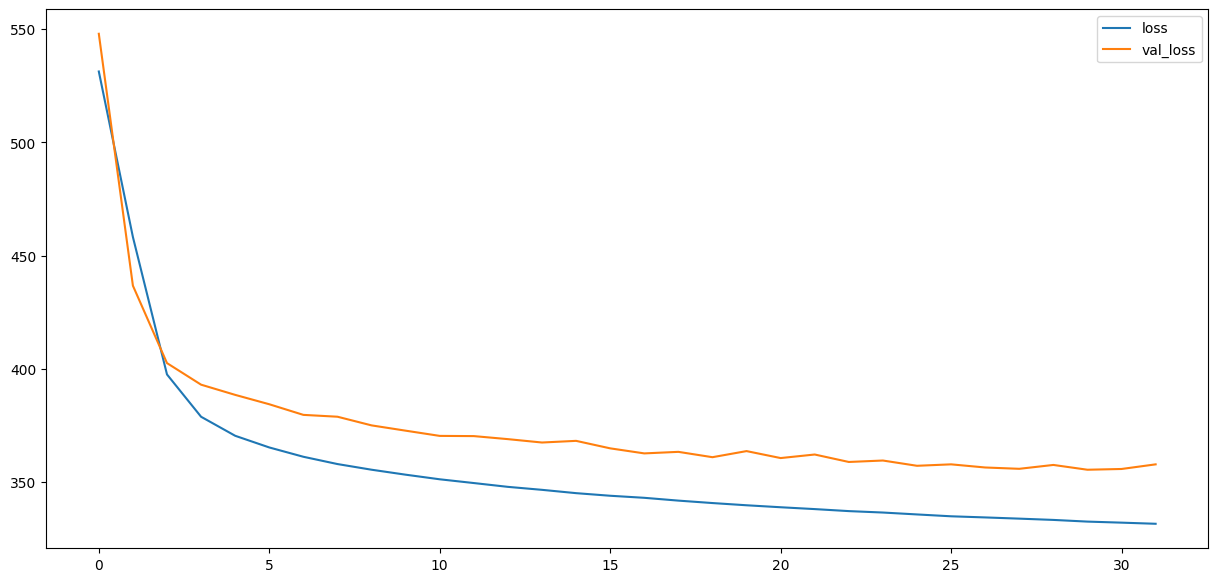

In [16]:
plt.figure(figsize=(15, 7))

for d in history.history.values():
    plt.plot(d)

plt.legend(history.history.keys())

### 7.2.4. Score

In [17]:
pred = model.predict(X_test)
pred

874/874 [==============================] - 0s 442us/step


array([[175.83032 ],
       [ 88.33397 ],
       [554.2358  ],
       ...,
       [ 66.16587 ],
       [ 64.86803 ],
       [ 87.321045]], dtype=float32)

In [18]:
mae = mean_absolute_error(y_test, pred)
mae

341.0579899204647

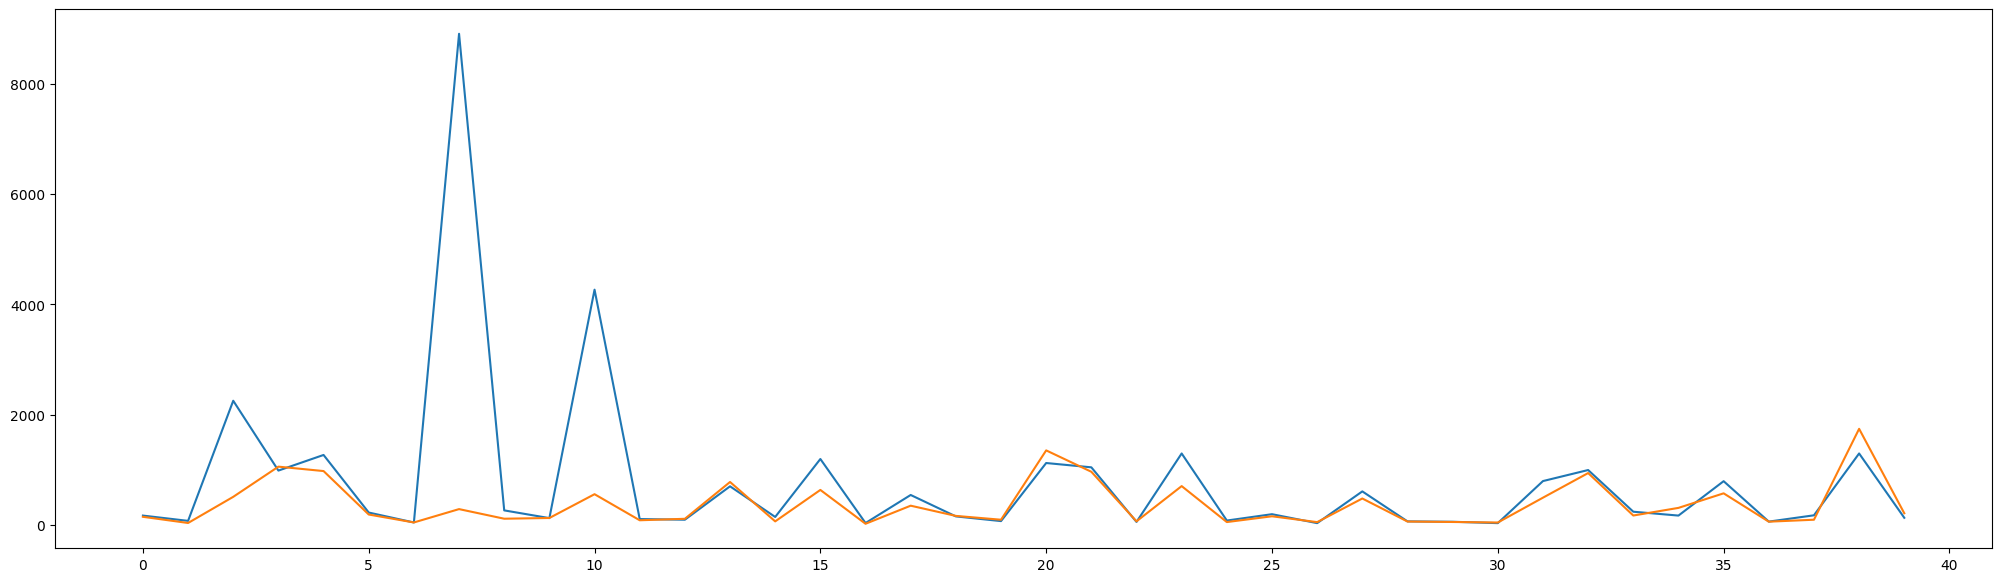

In [46]:
rng = slice(340, 380)

plt.figure(figsize=(25, 7))
plt.plot(y_test[rng].values)
plt.plot(pred[rng])

In [20]:
results = atomic_benchmark_estimator(model, X_test[:5000], verbose=True, kwargs_estimator_predict=dict(verbose=0))

atomic_benchmark runtimes: 0.026999235153198242 0.03099989891052246 0.17746925354003906


<Axes: >

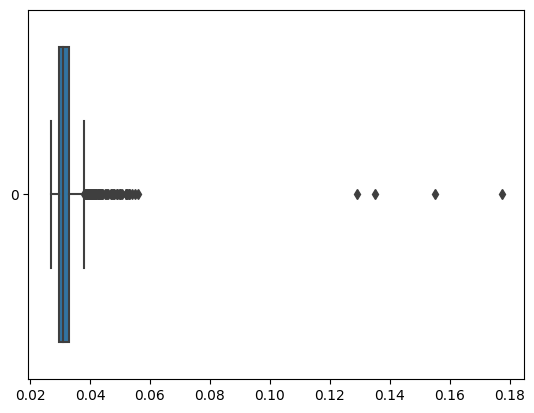

In [21]:
sns.boxplot(results, orient="h")

In [22]:
score = r2_score(y_test, pred)
score

0.08607269842268472

In [31]:
store_model_performance(
    model_name="randomized-searched-3-hidden-layers",
    R2_score=score,
    mae=mae,
    avarage_predication_time=results.mean(),
    parameters=search.best_params_,
)